# Load segmentation, localise and save as h5

Segment a stack of images and then manually label a couple, then check how well the model segmented them.

In [1]:
import napari
from cellpose import models
from octopuslite import utils, tile
import numpy as np

import sys
sys.path.append('macrohet/')
from notify import send_sms

def view(img):
    return napari.Viewer().add_image(img)

from tqdm.auto import tqdm

import btrack
import dask.array as da

import torch
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA RTX A6000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [2]:
image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/'
metadata_fn = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Index.idx.xml'
metadata = utils.read_harmony_metadata(metadata_fn)

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [3]:
metadata_path = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml'
utils.read_harmony_metadata(metadata_path, assay_layout=True)

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

### Define row and column of choice

In [18]:
row = '6'
column = '9'

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [33]:
images_dask = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, 
                             column, 
                             #set_channel=1, 
#                              set_plane = 'sum_proj',
#                              set_time = 1
                         )#.astype(uint8)

In [37]:
images_dask

,Array,Chunk
Bytes,30.66 GiB,46.51 MiB
Shape,"(75, 2, 3, 6048, 6048)","(1, 2, 3, 2016, 2016)"
Count,14850 Tasks,675 Chunks
Type,uint16,numpy.ndarray


# This is where the segmentation will go

In [6]:
model = models.Cellpose(
                        #gpu=True, 
                        model_type='cyto', 
                        net_avg=True, 
                        device=torch.device('cuda')
                        )

In [32]:
images

array([[[[   0,    0,    0, ...,    0,    0,    0],
         [ 321,  329,  317, ...,  430,  414,    0],
         [ 322,  324,  319, ...,  411,  419,    0],
         ...,
         [ 958, 1030,  988, ..., 1215, 1098,    0],
         [ 893,  972,  926, ..., 1490, 1296,    0],
         [ 852,  937,  871, ..., 1693, 1551,    0]],

        [[   0,    0,    0, ...,    0,    0,    0],
         [ 312,  298,  299, ...,  320,  327,    0],
         [ 303,  307,  304, ...,  317,  314,    0],
         ...,
         [ 308,  338,  349, ...,  321,  329,    0],
         [ 333,  349,  330, ...,  321,  322,    0],
         [ 331,  337,  306, ...,  305,  318,    0]]],


       [[[   0,    0,    0, ...,    0,    0,    0],
         [ 327,  332,  325, ...,  402,  402,    0],
         [ 314,  324,  324, ...,  399,  409,    0],
         ...,
         [1726, 1644, 1558, ..., 1034, 1014,    0],
         [1684, 1616, 1545, ..., 1073, 1021,    0],
         [1718, 1636, 1563, ..., 1084, 1111,    0]],

        [[   0

In [8]:
input_images = images[:,0,...]#.compute().compute().astype(np.uint16)
input_images

dask.array<getitem, shape=(75, 6048, 6048), dtype=uint64, chunksize=(1, 2016, 2016), chunktype=numpy.ndarray>

In [9]:
view(input_images)

Assistant skips harvesting pyclesperanto as it's not installed.


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'img' at 0x7f083fec9850>

In [ ]:
masks_stack = list()
for n, frame in tqdm(enumerate(input_images), total = len(input_images)):

    frame = frame.compute().compute().astype(np.uint16)
    masks, flows, styles, diams = model.eval(frame, 
                                             batch_size = 32, 
                                             channels = [0,0], 
                                             diameter = None, 
                                             min_size = 2500, 
                                             progress = True)
    masks_stack.append(masks)
masks_stack = da.stack(masks_stack, axis = 0)

  0%|          | 0/75 [00:00<?, ?it/s]

In [ ]:
masks = masks_stack

### Temporary: Load masks

In [24]:
masks_dict = np.load('/mnt/DATA/macrohet/segmentation/[6,9]_modified_mask_dict.npy', allow_pickle=True).item()
print(masks_dict.keys())

dict_keys([(200, 0.0), (200, 0.6), (250, 0.0), (300, 0.0), (300, 0.6), (200, 0.8)])


In [25]:
masks = masks_dict[(300,0.0)]

### Load images into memory for quicker editing

In [28]:
%%time 
masks = masks.compute()

CPU times: user 628 ms, sys: 345 ms, total: 973 ms
Wall time: 977 ms


In [31]:
%%time
images = images.compute().compute()

CPU times: user 3h 43min 38s, sys: 7min 9s, total: 3h 50min 47s
Wall time: 9min 31s


# Check masks 

and perform a quick post-segmentation cleaning on them

In [57]:
images.shape

(75, 6048, 6048, 2)

In [58]:
v = napari.Viewer()
v.add_image(images, 
            channel_axis = -1, 
            colormap=['green', 'magenta'], 
            contrast_limits=[[100,6000],[0,3000]])
# for key in masks_dict.keys():
#     v.add_labels(masks_dict[key][0], name = key)
v.add_labels(masks, name = 'masks')

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'masks' at 0x7f0748e7e790>

## Post-segmentation editing

In [24]:
from skimage.morphology import remove_small_objects, remove_small_holes, binary_erosion, square

In [108]:
###Q: do i need to remove small objects? don't think so
###Q: do i need to erode? no as am not binarising...
cleaned_masks = list()
for i, mask in tqdm(enumerate(masks), total = len(masks)):
    mask = binary_erosion(mask, square(5))
    mask = remove_small_holes(mask, area_threshold=50)
    cleaned_masks.append(mask)
cleaned_masks = np.stack(cleaned_masks, axis = 0)

  0%|          | 0/75 [00:00<?, ?it/s]

In [113]:
view(masks[37])

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'img' at 0x7f09b5f966a0>

#### Reorder the channel axis for localisation - dask

In [ ]:
gfp = images[:,0,...]
rfp = images[:,1,...]
images = da.stack([gfp,rfp], axis = -1)
images

In [ ]:
### convert to dask array so that it is compatible with images for localisation
masks = da.from_array(masks)

#### Reorder for channel axis for localisation - np.array

In [44]:
gfp = images[:,0,...]
rfp = images[:,1,...]
images = np.stack([gfp,rfp], axis = -1)
images

array([[[[   0,    0],
         [   0,    0],
         [   0,    0],
         ...,
         [   0,    0],
         [   0,    0],
         [   0,    0]],

        [[ 321,  312],
         [ 329,  298],
         [ 317,  299],
         ...,
         [ 430,  320],
         [ 414,  327],
         [   0,    0]],

        [[ 322,  303],
         [ 324,  307],
         [ 319,  304],
         ...,
         [ 411,  317],
         [ 419,  314],
         [   0,    0]],

        ...,

        [[ 958,  308],
         [1030,  338],
         [ 988,  349],
         ...,
         [1215,  321],
         [1098,  329],
         [   0,    0]],

        [[ 893,  333],
         [ 972,  349],
         [ 926,  330],
         ...,
         [1490,  321],
         [1296,  322],
         [   0,    0]],

        [[ 852,  331],
         [ 937,  337],
         [ 871,  306],
         ...,
         [1693,  305],
         [1551,  318],
         [   0,    0]]],


       [[[   0,    0],
         [   0,    0],
         [   0

In [46]:
masks.shape, images.shape

((75, 6048, 6048), (75, 6048, 6048, 2))

# Localise raw masks

Include size filter and measurements of fluorescence

In [47]:
feat = [
      "area",
      "major_axis_length",
      "minor_axis_length",
      "orientation",
      "mean_intensity",
        ]

In [48]:
objects = btrack.utils.segmentation_to_objects(
    masks, 
    images,
    properties = tuple(feat),
    use_weighted_centroid = False, 
)

[INFO][2023/01/24 01:57:57 pm] Localizing objects from segmentation...
24-Jan-23 13:57:57 - btrack._localization - INFO     - Localizing objects from segmentation...
[INFO][2023/01/24 01:57:57 pm] Found intensity_image data
24-Jan-23 13:57:57 - btrack._localization - INFO     - Found intensity_image data
[INFO][2023/01/24 02:03:58 pm] Objects are of type: <class 'dict'>
24-Jan-23 14:03:58 - btrack.dataio - INFO     - Objects are of type: <class 'dict'>
[INFO][2023/01/24 02:03:59 pm] ...Found 33992 objects in 75 frames.
24-Jan-23 14:03:59 - btrack._localization - INFO     - ...Found 33992 objects in 75 frames.


In [73]:
objects = [o for o in objects if o.properties['area'] > 2500]

In [1]:
test

NameError: name 'test' is not defined

#### Find the efd?

In [ ]:
### finding the EFD
for obj in tqdm(objects):
    ### extract the intensity image (1ch only)
    glimpse = obj.properties['intensity_image'][...,0]
    ### pad the glimpse to ensure only one object is identifiable
    glimpse = np.pad(glimpse, pad_width = 1)
    ### find the contours (zero because only one object)
    contours = skimage.measure.find_contours(glimpse, fully_connected='high', level = 0.5)[0]
    ### get the efd
    efd = elliptic_fourier_descriptors(contours, order=100, normalize=True)
#     obj.properties = {'efd': efd}
    flatten_efd = efd.flatten()
    obj.properties = {'efd flat': flatten_efd}

In [74]:
with btrack.dataio.HDF5FileHandler(
     f'/mnt/DATA/macrohet/segmentation/({row},{column})_objects_d300.h5',#
    'w', 
    obj_type='obj_type_1',
) as hdf:
    hdf.write_segmentation(masks)
    hdf.write_objects(objects)

[INFO][2023/01/24 02:36:37 pm] Opening HDF file: /mnt/DATA/macrohet/segmentation/(6,9)_objects_d300.h5...
24-Jan-23 14:36:37 - btrack.dataio - INFO     - Opening HDF file: /mnt/DATA/macrohet/segmentation/(6,9)_objects_d300.h5...
[INFO][2023/01/24 02:37:13 pm] Writing objects/obj_type_1
24-Jan-23 14:37:13 - btrack.dataio - INFO     - Writing objects/obj_type_1
[INFO][2023/01/24 02:37:13 pm] Writing labels/obj_type_1
24-Jan-23 14:37:13 - btrack.dataio - INFO     - Writing labels/obj_type_1
[INFO][2023/01/24 02:37:13 pm] Loading objects/obj_type_1 (33183, 5) (33183 filtered: None)
24-Jan-23 14:37:13 - btrack.dataio - INFO     - Loading objects/obj_type_1 (33183, 5) (33183 filtered: None)
[INFO][2023/01/24 02:37:13 pm] Writing properties/obj_type_1/area (33183,)
24-Jan-23 14:37:13 - btrack.dataio - INFO     - Writing properties/obj_type_1/area (33183,)
[INFO][2023/01/24 02:37:13 pm] Writing properties/obj_type_1/major_axis_length (33183,)
24-Jan-23 14:37:13 - btrack.dataio - INFO     - Wri

In [29]:
objects[0]

,ID,x,y,z,t,dummy,states,label,area,major_axis_length,minor_axis_length,orientation,mean_intensity-0,mean_intensity-1
0,0,257.838564,104.539205,0.0,0,False,7,5,36194,244.63143,204.217784,-0.625041,1751.473891,343.588302


In [107]:
config = '/home/dayn/analysis/BayesianTracker/models/cell_config.json'

In [78]:
features = list(objects[0].properties.keys())

In [108]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure(config)
    tracker.max_search_radius = 100
    tracker.tracking_updates = ["MOTION", "VISUAL"]
    tracker.features = features

    # append the objects to be tracked
    tracker.append(objects)

    # set the tracking volume
    tracker.volume=((0, masks.shape[-2]), (0, masks.shape[-1]))

    # track them (in interactive mode)
    tracker.track(step_size=25)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    # get the tracks in a format for napari visualization
    data, properties, graph = tracker.to_napari()
    
    # store the tracks
    tracks = tracker.tracks
    
    # store the configuration
    cfg = tracker.configuration
    
    # export the track data 
    tracker.export("/mnt/DATA/macrohet/segmentation/[6,9]_tracks.h5", obj_type="obj_type_1")
    

[INFO][2023/01/24 03:45:07 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
24-Jan-23 15:45:07 - btrack.libwrapper - INFO     - Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2023/01/24 03:45:07 pm] btrack (v0.5.0) library imported
24-Jan-23 15:45:07 - btrack.core - INFO     - btrack (v0.5.0) library imported
[INFO][2023/01/24 03:45:07 pm] Starting BayesianTracker session
24-Jan-23 15:45:07 - btrack.core - INFO     - Starting BayesianTracker session
[INFO][2023/01/24 03:45:07 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
24-Jan-23 15:45:07 - btrack.config - INFO     - Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2023/01/24 03:45:07 pm] Objects are of type: <class 'list'>
24-Jan-23 15:45:07 - btrack.dataio - INFO     - Objects are of type: <class 'list'>
[INFO][2023/01/24 03:45:08 pm] Starting tracking... 
24-Jan-23 15:45:08

GLPK Integer Optimizer 5.0
24360 rows, 19409 columns, 26655 non-zeros
19409 integer variables, all of which are binary
Preprocessing...
12180 rows, 19409 columns, 26655 non-zeros
19409 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 12180
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
12180 rows, 19409 columns, 26655 non-zeros
*     0: obj =   6.964964809e+04 inf =   0.000e+00 (3896)
Perturbing LP to avoid stalling [1734]...
Removing LP perturbation [3908]...
*  3908: obj =   4.505190000e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3908: mip =     not found yet >=              -inf        (1; 0)
+  3908: >>>>>   4.505190000e+04 >=   4.505190000e+04   0.0% (1; 0)
+  3908: mip =   4.505190000e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2023/01/24 03:45:35 pm] Opening HDF file: /mnt/DATA/macrohet/segmentation/[6,9]_tracks.h5...
24-Jan-23 15:45:35 - btrack.dataio - INFO     - Opening HDF file: /mnt/DATA/macrohet/segmentation/[6,9]_tracks.h5...
[INFO][2023/01/24 03:45:37 pm] Writing tracks/obj_type_1
24-Jan-23 15:45:37 - btrack.dataio - INFO     - Writing tracks/obj_type_1
[WARNING][2023/01/24 03:45:37 pm] Removing tracks/obj_type_1.
24-Jan-23 15:45:37 - btrack.dataio - WARNING  - Removing tracks/obj_type_1.
[INFO][2023/01/24 03:45:37 pm] Writing dummies/obj_type_1
24-Jan-23 15:45:37 - btrack.dataio - INFO     - Writing dummies/obj_type_1
[INFO][2023/01/24 03:45:37 pm] Writing LBEP/obj_type_1
24-Jan-23 15:45:37 - btrack.dataio - INFO     - Writing LBEP/obj_type_1
[INFO][2023/01/24 03:45:37 pm] Writing fates/obj_type_1
24-Jan-23 15:45:37 - btrack.dataio - INFO     - Writing fates/obj_type_1
[INFO][2023/01/24 03:45:37 pm] Closing HDF file: /mnt/DATA/macrohet/segmentation/[6,9]_tracks.h5
24-Jan-23 15:45:37 - btrack.

In [112]:
v = napari.Viewer()
v.add_image(images, 
            channel_axis = -1, 
            colormap=['green', 'magenta'], 
            contrast_limits=[[100,6000],[0,3000]])
# for key in masks_dict.keys():
#     v.add_labels(masks_dict[key][0], name = key)
v.add_labels(
    masks, 
    name = 'masks', 
    color = {1:'yellow'}, 
    opacity = 0.2
)
v.add_tracks(
                    data, 
                    properties=properties, 
                    graph=graph, 
                    name="Tracks [6,9]", 
                    blending="translucent",
                    visible=False,
                )


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Tracks layer 'Tracks [6,9]' at 0x7f0738bf6e50>

# Manually tweaking params for ideal tracking

##### first assess average displacement

Between ID 286 and 732

In [85]:
cell_286 = [cell for cell in tracks if cell.ID == 286][0]
cell_732 = [cell for cell in tracks if cell.ID == 732][0]

In [90]:
def euc_dist(cell1, cell2):
    dx = cell1.x[0] - cell2.x[0]
    dy = cell1.y[0] - cell2.y[0]
    return np.sqrt(dx**2+dy**2)

In [92]:
euc_dist(cell_286, cell_732)

86.96944647302901

In [86]:
cell_286

,ID,t,x,y,z,parent,root,state,generation,dummy,mean_intensity-1,minor_axis_length,major_axis_length,area,mean_intensity-0,orientation
0,286,0,1919.655413,1092.89281,0.0,286,286,5,0,False,"(1,) array","(1,) array","(1,) array","(1,) array","(1,) array","(1,) array"


In [101]:
0.6*0.6*0.6*0.6*0.6*0.6*0.6*0.6

0.016796159999999997

##### What happens to cell ID 388? Gets crowded out by another cell?

In [105]:
cell_388 = [cell for cell in tracks if cell.ID == 388][0]
cell_388

,ID,t,x,y,z,parent,root,state,generation,dummy,mean_intensity-1,minor_axis_length,major_axis_length,area,mean_intensity-0,orientation
0,388,0,773.977808,813.659887,0.000000,388,388,5,0,False,418.746670,207.224405,381.339830,60968.0,1189.934769,-0.130365
1,388,1,778.502292,826.736522,0.000000,388,388,5,0,False,420.123396,215.825863,405.684751,67182.0,1190.718466,-0.154894
2,388,2,783.206997,837.855339,1.311342,388,388,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
3,388,3,784.923151,822.801258,0.000000,388,388,5,0,False,412.731063,228.597218,391.542236,68979.0,1082.104046,-0.246876
4,388,4,788.145804,822.501875,-0.013909,388,388,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
5,388,5,791.368457,822.202493,-0.027819,388,388,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
6,388,6,804.306828,829.304345,0.000000,388,388,5,0,False,415.131923,259.637272,359.704414,68866.0,1201.234876,-0.165134


# Dist of track lens

In [1]:
import btrack

In [3]:
with btrack.dataio.HDF5FileHandler('/mnt/DATA/macrohet/segmentation/tracks_objs/tracks_arx/rescaled_[6,9]_tracks.h5', 'r') as hdf:
    tracks = hdf.tracks

[INFO][2023/02/28 04:14:43 PM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/tracks_arx/rescaled_[6,9]_tracks.h5...
[INFO][2023/02/28 04:14:43 PM] Loading tracks/obj_type_1
[INFO][2023/02/28 04:14:43 PM] Loading LBEP/obj_type_1
[INFO][2023/02/28 04:14:43 PM] Loading objects/obj_type_1 (26073, 5) (26073 filtered: None)
[INFO][2023/02/28 04:14:44 PM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/tracks_arx/rescaled_[6,9]_tracks.h5


In [4]:
import matplotlib.pyplot as plt

In [5]:
lengths = [len(track) for track in tracks]

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme(style="ticks")
sns.set_palette("Spectral")

(array([1538.,  298.,  127.,   73.,   42.,   38.,   61.]),
 array([ 1.        , 11.57142857, 22.14285714, 32.71428571, 43.28571429,
        53.85714286, 64.42857143, 75.        ]),
 <BarContainer object of 7 artists>)

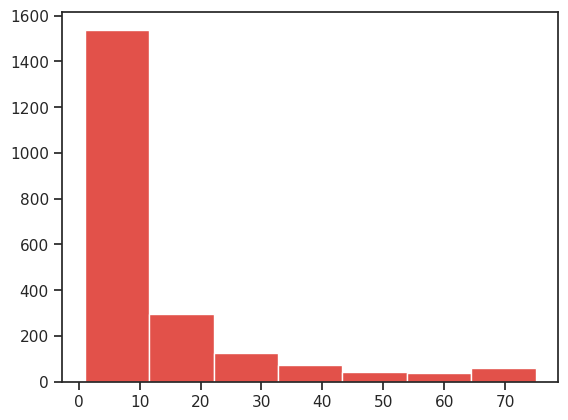

In [17]:
plt.hist(lengths, bins=7)

(array([3390.,  984.,  379.,  178.,  112.,   64.,   35.,   21.,   11.,
          11.]),
 array([ 1. ,  8.4, 15.8, 23.2, 30.6, 38. , 45.4, 52.8, 60.2, 67.6, 75. ]),
 <BarContainer object of 10 artists>)

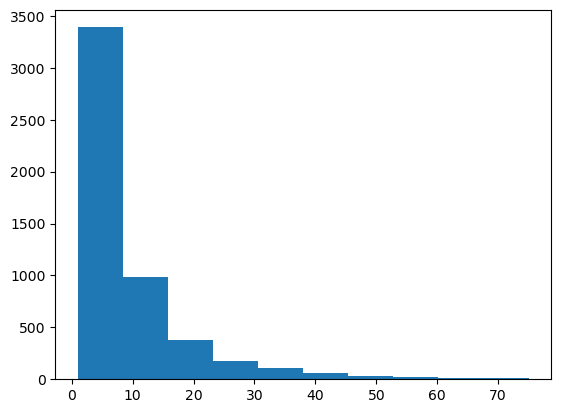

In [111]:
plt.hist(lengths)

# Test dataset

In [121]:
from btrack import datasets
from skimage.io import imread

In [124]:
SEGMENTATION_FILE = datasets.example_segmentation_file()
CONFIG_FILE = datasets.cell_config()
segmentation = imread(SEGMENTATION_FILE)

In [123]:
FEATURES = [
    "area", 
    "major_axis_length", 
    "minor_axis_length", 
    "orientation", 
    "solidity"
]

example_objects = btrack.utils.segmentation_to_objects(
    segmentation, 
    properties=tuple(FEATURES), 
)

[INFO][2023/01/24 03:52:53 pm] Localizing objects from segmentation...
24-Jan-23 15:52:53 - btrack._localization - INFO     - Localizing objects from segmentation...
[INFO][2023/01/24 03:54:16 pm] Objects are of type: <class 'dict'>
24-Jan-23 15:54:16 - btrack.dataio - INFO     - Objects are of type: <class 'dict'>
[INFO][2023/01/24 03:54:17 pm] ...Found 52890 objects in 500 frames.
24-Jan-23 15:54:17 - btrack._localization - INFO     - ...Found 52890 objects in 500 frames.


In [125]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure(CONFIG_FILE)
    tracker.max_search_radius = 50
    tracker.tracking_updates = ["MOTION", "VISUAL"]
    tracker.features = FEATURES

    # append the objects to be tracked
    tracker.append(example_objects)

    # set the tracking volume
    tracker.volume=((0, 1600), (0, 1200))

    # track them (in interactive mode)
    tracker.track(step_size=100)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    # get the tracks in a format for napari visualization
    eg_data, eg_properties, eg_graph = tracker.to_napari()
    
    # store the tracks
    eg_tracks = tracker.tracks
    
    # store the configuration
    eg_cfg = tracker.configuration


[INFO][2023/01/24 03:54:19 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
24-Jan-23 15:54:19 - btrack.libwrapper - INFO     - Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2023/01/24 03:54:19 pm] btrack (v0.5.0) library imported
24-Jan-23 15:54:19 - btrack.core - INFO     - btrack (v0.5.0) library imported
[INFO][2023/01/24 03:54:19 pm] Starting BayesianTracker session
24-Jan-23 15:54:19 - btrack.core - INFO     - Starting BayesianTracker session
[INFO][2023/01/24 03:54:19 pm] Loading configuration file: /home/dayn/.cache/btrack-examples/examples/cell_config.json
24-Jan-23 15:54:19 - btrack.config - INFO     - Loading configuration file: /home/dayn/.cache/btrack-examples/examples/cell_config.json
[INFO][2023/01/24 03:54:19 pm] Objects are of type: <class 'list'>
24-Jan-23 15:54:19 - btrack.dataio - INFO     - Objects are of type: <class 'list'>
[INFO][2023/01/24 03:54:21 pm] Starting tracking... 
24-Jan-23 15:54:21

GLPK Integer Optimizer 5.0
1344 rows, 1119 columns, 1592 non-zeros
1119 integer variables, all of which are binary
Preprocessing...
672 rows, 1119 columns, 1592 non-zeros
1119 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 672
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
672 rows, 1119 columns, 1592 non-zeros
*     0: obj =   2.128776612e+03 inf =   0.000e+00 (153)
*   130: obj =   1.045172041e+03 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+   130: mip =     not found yet >=              -inf        (1; 0)
+   130: >>>>>   1.045172041e+03 >=   1.045172041e+03   0.0% (1; 0)
+   130: mip =   1.045172041e+03 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND


[INFO][2023/01/24 03:54:26 pm] Ending BayesianTracker session
24-Jan-23 15:54:26 - btrack.core - INFO     - Ending BayesianTracker session


In [127]:
viewer = napari.Viewer()

viewer.add_image(
    segmentation, 
    name="Segmentation",
    opacity=0.2,
)

# the track data from the tracker
viewer.add_tracks(
    eg_data, 
    properties=eg_properties, 
    graph=eg_graph, 
    name="example Tracks", 
    blending="translucent",
    visible=True,
)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Tracks layer 'example Tracks' at 0x7f075e5c8550>